## Imports

In [1]:
import pandas as pd
import numpy as np
import regex as re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

## Submission Flag

In [2]:
is_submission = False

## Read Datasets

In [3]:
train_path = r"data\train_v2_drcat_02.csv" if not is_submission else r"/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv"
test_path = r"data\train_essays.csv" if not is_submission else r"/kaggle/input/llm-detect-ai-generated-text/train_essays.csv"
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [4]:
train_ = train_data[train_data.RDizzl3_seven == False].reset_index(drop=True)
train_ = train_data[train_data["label"]==1].sample(8000)
train = train_data[train_data.RDizzl3_seven == True].reset_index(drop=True)
train = pd.concat([train, train_])
train['text'] = train['text'].str.replace('\n', '')
test_data['text'] = test_data['text'].str.replace('\n', '')
train['label'].value_counts()

label
0    14250
1    14200
Name: count, dtype: int64

## Embeddings

In [5]:
vectorizer = TfidfVectorizer(ngram_range=(3, 5),
                             tokenizer=lambda x: re.findall(r'[^\W]+', x),
                             token_pattern=None,
                             strip_accents='unicode',)
vectorized_train_data = vectorizer.fit_transform(train_data["text"])
vectorized_test_data = vectorizer.transform(test_data["text"])

## Create Model

In [8]:
lr_model=LogisticRegression()
clf_model = MultinomialNB(alpha=0.02)
sgd_model1 = SGDClassifier(max_iter=8000, tol=1e-3, loss="modified_huber")   
sgd_model2 = SGDClassifier(max_iter=10000, tol=5e-4, loss="modified_huber", class_weight="balanced") 
sgd_model3 = SGDClassifier(max_iter=15000, tol=3e-4, loss="modified_huber", early_stopping=True)
ensemble = VotingClassifier(estimators=[('lr', lr_model),
                                        ('mnb', clf_model),
                                        ('sgd1', sgd_model1),
                                        ('sgd2', sgd_model2),
                                        ('sgd3', sgd_model3),
                                       ],
                            weights=[0.20, 0.20, 0.20, 0.20, 0.20],
                            voting='soft'
                           )

## Fit Model

In [9]:
ensemble.fit(vectorized_train_data[:train.shape[0]], train.label)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('mnb', MultinomialNB(alpha=0.02)),
                             ('sgd1',
                              SGDClassifier(loss='modified_huber',
                                            max_iter=8000)),
                             ('sgd2',
                              SGDClassifier(class_weight='balanced',
                                            loss='modified_huber',
                                            max_iter=10000, tol=0.0005)),
                             ('sgd3',
                              SGDClassifier(early_stopping=True,
                                            loss='modified_huber',
                                            max_iter=15000, tol=0.0003))],
                 voting='soft', weights=[0.2, 0.2, 0.2, 0.2, 0.2])

## Predict Test Set

In [10]:
predictions = ensemble.predict(vectorized_test_data).astype(float)

[[847 528]
 [  0   3]]


<Axes: >

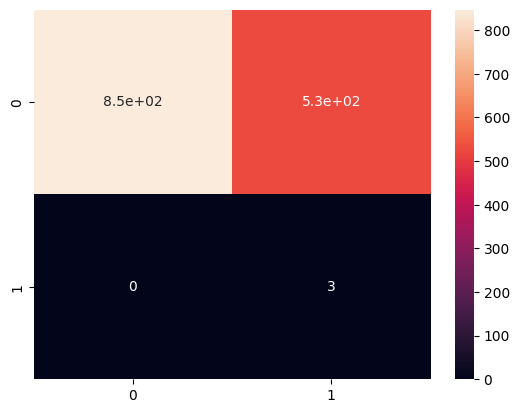

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(test_data['generated'], predictions)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True)

## Create Submission

In [16]:
submission = pd.DataFrame({"id": test_data["id"], "generated": predictions})
submission_path = r"data\submission.csv" if not is_submission else r"/kaggle/working/submission.csv"
submission.to_csv(submission_path, index=False)